In [ ]:
import os
from glob import glob

import numpy as np
from matplotlib import pyplot as plt

import pyart

import cp2_common as common
import attenuation
import rainrate


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [5]:
"""
1: Radar QC (remove non-precip)
2: kdp use linear fitting and smoothing over 25 (9) ranges gates when Z was less (greater) than 40dBZ

3: Z-Zdr pairs with Z between 20 and 50dB are grouped into sizteen 2dB bins, and then the mean values
estimate alpha for those gates with rhohv>0.98 and Z between 20 and 50 dBZ (from 0.5 degree tilt, below melting region), 
mean values for each bin are calculated and alpha estimated using the relationship slope. 
Minimum of 30,000 pairs with a default alpha of 0.015dB (pairs are reset after each update)
Rainfall retrieval applied to 5 - 50 dBZ range
Melting layer defined as Hm=(H0 + H10)/2 at the radar site

"""

'\n1: Radar QC (remove non-precip)\n2: kdp use linear fitting and smoothing over 25 (9) ranges gates when Z was less (greater) than 40dBZ\n\n3: Z-Zdr pairs with Z between 20 and 50dB are grouped into sizteen 2dB bins, and then the mean values\nestimate alpha for those gates with rhohv>0.98 and Z between 20 and 50 dBZ (from 0.5 degree tilt, below melting region), \nmean values for each bin are calculated and alpha estimated using the relationship slope. \nMinimum of 30,000 pairs with a default alpha of 0.015dB (pairs are reset after each update)\nRainfall retrieval applied to 5 - 50 dBZ range\nMelting layer defined as Hm=(H0 + H10)/2 at the radar site\n\n'

In [9]:
#files to process
derived_path = '/g/data/hj10/admin/cp2/level_1/derived/sur/2014/20141127'
level_1b_path = '/g/data/hj10/admin/cp2/level_1b_testing/v2020/ppi/2014/20141127'
vol_ffn_list = sorted(glob(level_1b_path + '/*.nc'))

#output
output_path = '/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/cp2'

#init alpha dict
alpha_dict = {'z_pairs':[], 'zdr_pairs':[], 'alpha_ts':[], 'dt_ts':[]}

#note, check file 11, has a mask error

for vol_ffn in vol_ffn_list:
    print('processing', vol_ffn)

    #read radar
    radar = pyart.io.read(vol_ffn)

    #generate temp data
    radar = common.generate_isom(radar)

    #generate gatefilter for nonprecip
    #radar = common.add_ncar_pid(radar, derived_path, vol_ffn)

    #estimate alpha
    alpha_dict = attenuation.estimate_alpha(radar, alpha_dict)
    
    #estimate specific attenuation
    alpha = alpha_dict['alpha_ts'][-1]
    radar = attenuation.retrieve_zphi(radar, alpha=alpha)

    #estimate rainfall
    radar = rainrate.conventional(radar, alpha=92, beta=1.7)
    radar = rainrate.polarimetric(radar)

    #save to file
    cfradial_ffn = output_path + '/' + os.path.basename(vol_ffn)
    pyart.io.write_cfradial(cfradial_ffn, radar)

#save alpha timeseries to file
alpha_ffn = output_path + '/' + os.path.basename(derived_path) + '_alpha_ts.npz'
alpha_ts_array = np.array(alpha_dict['alpha_ts'])
dt_ts_array    = np.array(alpha_dict['dt_ts'])
np.savez(alpha_ffn, alpha_ts_array, dt_ts_array)

processing /g/data/hj10/admin/cp2/level_1b_sband_sur/v2020/ppi/2014/20141127/cp2-s_20141127_000456.sur.cfradial.nc
processing /g/data/hj10/admin/cp2/level_1b_sband_sur/v2020/ppi/2014/20141127/cp2-s_20141127_001057.sur.cfradial.nc
processing /g/data/hj10/admin/cp2/level_1b_sband_sur/v2020/ppi/2014/20141127/cp2-s_20141127_001700.sur.cfradial.nc
processing /g/data/hj10/admin/cp2/level_1b_sband_sur/v2020/ppi/2014/20141127/cp2-s_20141127_002257.sur.cfradial.nc
processing /g/data/hj10/admin/cp2/level_1b_sband_sur/v2020/ppi/2014/20141127/cp2-s_20141127_002856.sur.cfradial.nc
processing /g/data/hj10/admin/cp2/level_1b_sband_sur/v2020/ppi/2014/20141127/cp2-s_20141127_003457.sur.cfradial.nc
processing /g/data/hj10/admin/cp2/level_1b_sband_sur/v2020/ppi/2014/20141127/cp2-s_20141127_004057.sur.cfradial.nc
processing /g/data/hj10/admin/cp2/level_1b_sband_sur/v2020/ppi/2014/20141127/cp2-s_20141127_004702.sur.cfradial.nc
processing /g/data/hj10/admin/cp2/level_1b_sband_sur/v2020/ppi/2014/20141127/cp2

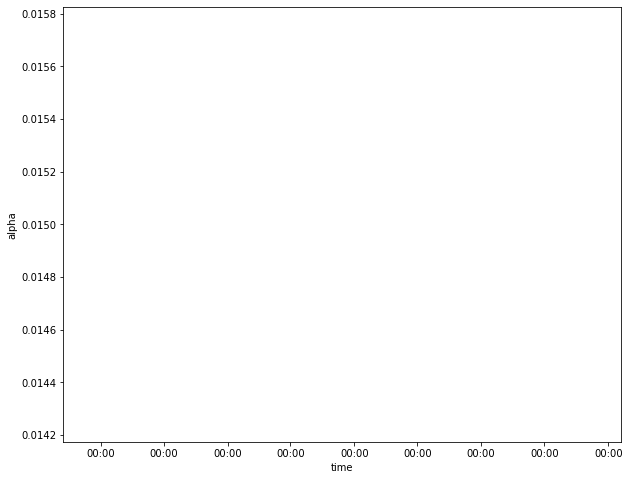

In [8]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=[10,8])
plt.plot(alpha_dict['dt_ts'], alpha_dict['alpha_ts'], 'r-')
plt.xlabel('time')
plt.ylabel('alpha')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))